In [1]:
import os
os.getcwd()


'C:\\Users\\Zara\\bioinformatics_MADI'

In [2]:
import os
os.chdir("C:\\Users\\Zara\\bioinformatics_MADI")

In [3]:
import os
os.getcwd()

'C:\\Users\\Zara\\bioinformatics_MADI'

In [4]:
import os
os.chdir("C:\\Users\\Zara\\bioinformatics_MADI")

In [5]:
import os
os.getcwd()

'C:\\Users\\Zara\\bioinformatics_MADI'

In [6]:
!pip install pandas

In [7]:
import pandas as pd

expr_df = pd.read_csv("TCGA-count-data.csv", index_col=0)
meta_df = pd.read_csv("TCGA-column-data.csv", index_col=0)

display(expr_df.shape)
display(meta_df.shape)

(60660, 168)

(168, 1)

In [8]:
display(expr_df.shape)
meta_df

(60660, 168)

,condition
ID,
TCGA-FB-AAPY-01A,cancer
TCGA-IB-A7LX-01A,cancer
TCGA-XN-A8T5-01A,cancer
TCGA-HZ-A77O-01A,cancer
TCGA-FB-AAPQ-01A,cancer
...,...
TCGA-YY-A8LH-01A,cancer
TCGA-HV-A5A3-11A,normal
TCGA-H6-A45N-11A,normal


In [9]:
# check for any missing values, # total number of NA cells
print(expr_df.isna().sum().sum())

1


In [10]:
# remove rows with any NA or fill NA with zeros
# expr_df = expr_df.dropna(axis=0) # drop genes with any NA counts
expr_df = expr_df.fillna(0) 

In [11]:
# check for missing values again 
print(expr_df.isna().sum().sum())

0


In [12]:
##check--samples are in same order in both input files
if list(expr_df.columns) == list(meta_df.index):
    print("sample names are already in the correct order.")
else:
    print("sample names are not in same order. reordering needed.")

sample names are already in the correct order.


In [13]:
#select all rows (:) and only the columns in expr_df whose names match the index of meta_df, preventing the
#expr_df = expr_df.Loc[:, meta_df.index]

In [14]:
!pip install rpy2
import rpy2.robjects as robjects
print("rpy2 is working!")

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


rpy2 is working!


In [15]:
##install DESeq2 directly from your Python script using:
import rpy2.robjects.packages as rpackages

#install BiocManager first
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

# install BiocManager (if not available)
if not rpackages.isinstalled("BiocManager"):
    utils.install_packages("BiocManager") 

# Use BiocManager to install DESeq2
biocmanager = rpackages.importr("BiocManager")
biocmanager.install("DESeq2")


R callback write-console: 'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org
  
R callback write-console: Bioconductor version 3.20 (BiocManager 1.30.26), R 4.4.3 (2025-02-28 ucrt)
  
R callback write-console: Installation paths not writeable, unable to update packages
  path: C:/Program Files/R/R-4.4.3/library
  packages:
    boot, cluster, foreign, lattice, MASS, Matrix, mgcv, nlme
  
R callback write-console: Old packages: 'BiocParallel', 'oligo'
  


Update all/some/none? [a/s/n]: 

 n


'DESeq2'


In [17]:
#Test after installation:
from rpy2.robjects.packages import importr
deseq2 = importr("DESeq2") 

In [18]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# 🔹 Load your expression count data and metadata
# expr_df = pd.read_csv("TCGA-count-data.csv", index_col=0)
# meta_df = pd.read_csv("TCGA-column-data.csv", index_col=0)

# Ensure column order matches between counts and metadata
# expr_df = expr_df.loc[:, meta_df.index]

# 🔹 Convert pandas → R
with localconverter(ro.default_converter + pandas2ri.converter):
    r_counts = ro.conversion.py2rpy(expr_df)
    r_coldata = ro.conversion.py2rpy(meta_df)

# Assign R objects into the R environment
ro.globalenv["countData"] = r_counts
ro.globalenv["colData"] = r_coldata

# 🔹 Import DESeq2
deseq2 = importr("DESeq2")

# 🔹 Run DESeq2 in R
ro.r('''
    library(DESeq2)

    # Ensure the 'condition' column exists in colData
    colData$condition <- factor(colData$condition)

    # Create DESeq2 dataset
    dds <- DESeqDataSetFromMatrix(countData = countData,
                                  colData = colData,
                                  design = ~ condition)

    # Run DESeq normalization & model fitting
    dds <- DESeq(dds)

    # Extract results table
    res <- results(dds)

    # Convert to data.frame for export to Python
    res_df <- as.data.frame(res)
''')

# 🔹 Convert the R DataFrame → Pandas DataFrame
with localconverter(ro.default_converter + pandas2ri.converter):
    res_df = ro.conversion.rpy2py(ro.globalenv["res_df"])

# 🔹 Format nicely
res_df.index.name = "Gene"
res_df.reset_index(inplace=True)

# 🔹 View results
print(res_df.head())

R callback write-console: converting counts to integer mode
  
R callback write-console: estimating size factors
  
R callback write-console: estimating dispersions
  
R callback write-console: gene-wise dispersion estimates
  
R callback write-console: mean-dispersion relationship
  
R callback write-console: final dispersion estimates
  
R callback write-console: fitting model and testing
  
R callback write-console: -- replacing outliers and refitting for 9198 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
  
R callback write-console: estimating dispersions
  
R callback write-console: fitting model and testing
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DESeq2' 
  


                 Gene     baseMean  log2FoldChange     lfcSE      stat  \
0  ENSG00000000003.15  1742.370112        0.205592  0.384009  0.535382   
1   ENSG00000000005.6    12.808441        2.990998  1.424179  2.100157   
2  ENSG00000000419.13  1405.978785       -0.281960  0.193318 -1.458528   
3  ENSG00000000457.14   704.746381       -0.195765  0.236421 -0.828036   
4  ENSG00000000460.17   216.225345       -0.294579  0.280630 -1.049706   

     pvalue      padj  
0  0.592386  0.864053  
1       NaN       NaN  
2  0.144695  0.533245  
3  0.407650  0.765484  
4  0.293853  0.687396  


In [19]:
##export results to csv file
#upregulated genes
upregulated = res_df[(res_df['padj'] < 0.05) & (res_df['log2FoldChange'] > 1)]

#downregulated genes
downregulated = res_df[(res_df['padj'] < 0.05) & (res_df['log2FoldChange'] < -1)]

upregulated.to_csv("upregulated_genes.csv", index=False)
downregulated.to_csv("downregulated_genes.csv", index=False)




In [20]:
!pip install matplotlib seaborn


In [21]:
##VOLCANO PLOT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
#chatgpt

Index(['Gene', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       '-log10_pval', 'category'],
      dtype='object')


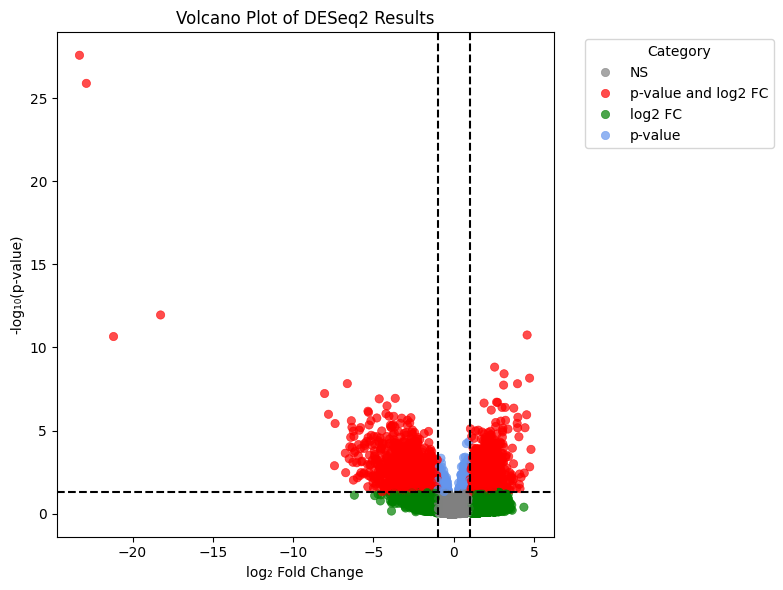

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example thresholds
log2fc_thresh = 1.0   # |log2FoldChange| > 1
pval_thresh = 0.05    # pvalue < 0.05

# Make sure column names match those from DESeq2
# (Common ones: 'log2FoldChange', 'pvalue', 'padj')
print(res_df.columns)

# Define categorization function
def get_category(row):
    if np.isnan(row['pvalue']) or np.isnan(row['log2FoldChange']):
        return 'NS'
    elif row['pvalue'] < pval_thresh and abs(row['log2FoldChange']) > log2fc_thresh:
        return 'p-value and log2 FC'
    elif row['pvalue'] < pval_thresh:
        return 'p-value'
    elif abs(row['log2FoldChange']) > log2fc_thresh:
        return 'log2 FC'
    else:
        return 'NS'

# Apply classification
res_df['category'] = res_df.apply(get_category, axis=1)

# Color palette
colors = {
    'NS': 'grey',
    'log2 FC': 'green',
    'p-value': 'cornflowerblue',
    'p-value and log2 FC': 'red'
}

# Volcano plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=res_df,
    x='log2FoldChange',
    y=-np.log10(res_df['pvalue']),
    hue='category',
    palette=colors,
    alpha=0.7,
    edgecolor=None
)

plt.axvline(x=log2fc_thresh, color='black', linestyle='--')
plt.axvline(x=-log2fc_thresh, color='black', linestyle='--')
plt.axhline(y=-np.log10(pval_thresh), color='black', linestyle='--')

plt.title('Volcano Plot of DESeq2 Results')
plt.xlabel('log₂ Fold Change')
plt.ylabel('-log₁₀(p-value)')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [28]:
!pip install plotly

In [29]:
# interactive volcano plot

import plotly.express as px
import numpy as np
import pandas as pd

# assume 'res_df' contains: 'Gene', 'log2foldchange', 'padj'

#clean data
res_df_clean = res_df.dropna(subset=['log2FoldChange', 'padj']).copy()
res_df_clean['-log10(padj)'] = -np.log10(res_df_clean['padj'])

#define significance 
res_df_clean['significance'] = 'Not Significant'
res_df_clean.loc(res_df_clean['padj'] < 0.05) & [(res_df_clean['log2FoldChange'] > 1), 'Significance'] = 'Upregulated'
res_df_clean.loc(res_df_clean['padj'] < 0.05) & [(res_df_clean['log2FoldChange'] < -1), 'Significance'] = 'Downregulated'

#define genes to highlight
highlight_genes = ['ENSG00000000003.15', 'ENSG00000000419.13', 'ENSG00000000457.14']
res_df_clean['Highlight'] = res_df_clean['Gene'].isin(highlight_genes)

#create hover label
res_df_clean['text'] = res_df_clean['Gene'] + "<br>log2FC: " + res_df_clean['log2FoldChange'].round(2).astype(str) + \
                       "<br>padj: " + res_df_clean['padj'].apply(lambda x: f"{x:.2e}")

#plotly volcano plot
fig = px.scatter(
    res_df_clean,
    x='log2FoldChange',
    y='-log10(padj)',
    color='Significance',
    hover_name='Gene',
    hover_data={'padj':True, 'log2FoldChange': True, '-log10(padj)': False},
    symbol='Highlight',
    color_discrete_map={
        'Upregulated': 'red',
        'Downregulated': 'blue',
        'Not Significant': 'grey'
    },
    title='Interactive Volcano Plot (Hover + Highlighted Genes)',
    width=900,
    height=600
)

# threshold lines
fig.add_shape(type="line", x0=-1, x1=-1, y0=0, y1=res_df_clean['-log10(padj)'].max(),
              line=dict(dash='dash', color='black'))
fig.add_shape(type="line", x0=1, x1=1, y0=0, y1=res_df_clean['-log10(padj)'].max(),
              line=dict(dash='dash', color='black'))
fig.add_shape(type="line", x0=res_df_clean['log2FoldChange'].min(), x1=res_df_clean['log2FoldChange'].max(),
              y0=-np.log10(0.05), y1=-np.log10(0.05), line=dict(dash='dash', color='black'))

#update layout
fig.update_traces(marker=dict(size=6), selector=dict(mode='markers'))
fig.update_layout(showlegend=True)

#show interactive plot
fig.show()



SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (3405685261.py, line 15)

In [30]:
import plotly.express as px
import numpy as np
import pandas as pd

# Assume 'res_df' contains: 'Gene', 'log2FoldChange', 'padj'

# Clean data
res_df_clean = res_df.dropna(subset=['log2FoldChange', 'padj']).copy()
res_df_clean['-log10(padj)'] = -np.log10(res_df_clean['padj'])

# Define significance
res_df_clean['Significance'] = 'Not Significant'
res_df_clean.loc[
    (res_df_clean['padj'] < 0.05) & (res_df_clean['log2FoldChange'] > 1),
    'Significance'
] = 'Upregulated'
res_df_clean.loc[
    (res_df_clean['padj'] < 0.05) & (res_df_clean['log2FoldChange'] < -1),
    'Significance'
] = 'Downregulated'

# Define genes to highlight
highlight_genes = [
    'ENSG00000000003.15',
    'ENSG00000000419.13',
    'ENSG00000000457.14'
]
res_df_clean['Highlight'] = res_df_clean['Gene'].isin(highlight_genes)

# Create hover label
res_df_clean['text'] = (
    res_df_clean['Gene']
    + "<br>log2FC: "
    + res_df_clean['log2FoldChange'].round(2).astype(str)
    + "<br>padj: "
    + res_df_clean['padj'].apply(lambda x: f"{x:.2e}")
)

# Interactive volcano plot
fig = px.scatter(
    res_df_clean,
    x='log2FoldChange',
    y='-log10(padj)',
    color='Significance',
    hover_name='Gene',
    hover_data={'padj': True, 'log2FoldChange': True, '-log10(padj)': False},
    symbol='Highlight',
    color_discrete_map={
        'Upregulated': 'red',
        'Downregulated': 'blue',
        'Not Significant': 'grey'
    },
    title='Interactive Volcano Plot (Hover + Highlighted Genes)',
    width=900,
    height=600
)

# Threshold lines
fig.add_shape(type="line", x0=-1, x1=-1, y0=0, y1=res_df_clean['-log10(padj)'].max(),
              line=dict(dash='dash', color='black'))
fig.add_shape(type="line", x0=1, x1=1, y0=0, y1=res_df_clean['-log10(padj)'].max(),
              line=dict(dash='dash', color='black'))
fig.add_shape(type="line",
              x0=res_df_clean['log2FoldChange'].min(),
              x1=res_df_clean['log2FoldChange'].max(),
              y0=-np.log10(0.05),
              y1=-np.log10(0.05),
              line=dict(dash='dash', color='black'))

# Layout tweaks
fig.update_traces(marker=dict(size=6), selector=dict(mode='markers'))
fig.update_layout(showlegend=True)

# Show interactive plot
fig.show()


In [33]:
##export results to csv file
#upregulated genes
upregulated = res_df[(res_df['padj'] < 0.05) & (res_df['log2FoldChange'] > 1)]

#downregulated genes
downregulated = res_df[(res_df['padj'] < 0.05) & (res_df['log2FoldChange'] < -1)]

upregulated.to_csv("upregulated_genes.csv", index=False)
downregulated.to_csv("downregulated_genes.csv", index=False)

In [34]:
# select top genes based on p-value and log2FC
top_n = 50
top_genes = res_df.sort_values('pvalue').head(top_n)['Gene'].tolist()

In [35]:
top_genes

['ENSG00000090402.8',
 'ENSG00000110245.12',
 'ENSG00000204019.5',
 'ENSG00000248115.1',
 'ENSG00000164816.8',
 'ENSG00000188375.5',
 'ENSG00000223668.1',
 'ENSG00000136011.15',
 'ENSG00000167653.5',
 'ENSG00000156886.12',
 'ENSG00000150045.12',
 'ENSG00000043355.12',
 'ENSG00000089356.18',
 'ENSG00000272620.2',
 'ENSG00000233143.2',
 'ENSG00000279166.1',
 'ENSG00000237757.2',
 'ENSG00000166143.10',
 'ENSG00000229140.11',
 'ENSG00000168356.13',
 'ENSG00000264345.2',
 'ENSG00000241560.7',
 'ENSG00000130720.13',
 'ENSG00000114248.10',
 'ENSG00000144452.15',
 'ENSG00000163283.7',
 'ENSG00000229436.1',
 'ENSG00000124664.11',
 'ENSG00000173702.7',
 'ENSG00000262406.3',
 'ENSG00000179913.11',
 'ENSG00000117983.17',
 'ENSG00000274414.1',
 'ENSG00000117472.10',
 'ENSG00000143869.7',
 'ENSG00000166535.20',
 'ENSG00000187908.20',
 'ENSG00000073861.3',
 'ENSG00000226239.2',
 'ENSG00000060140.9',
 'ENSG00000173557.15',
 'ENSG00000163687.14',
 'ENSG00000198788.9',
 'ENSG00000224511.2',
 'ENSG000001

In [36]:
##expression matrix for top genes

top_expr = expr_df.loc[expr_df.index.intersection(top_genes)]

In [37]:
top_expr

,TCGA-FB-AAPY-01A,TCGA-IB-A7LX-01A,TCGA-XN-A8T5-01A,TCGA-HZ-A77O-01A,TCGA-FB-AAPQ-01A,TCGA-3A-A9IL-01A,TCGA-FB-AAPS-01A,TCGA-IB-A7M4-01A,TCGA-IB-8126-01A,TCGA-FB-AAPP-01A,...,TCGA-FB-A78T-01A,TCGA-HZ-7919-01A,TCGA-IB-AAUP-01A,TCGA-2J-AABI-01A,TCGA-3A-A9IV-01A,TCGA-YY-A8LH-01A,TCGA-HV-A5A3-11A,TCGA-H6-A45N-11A,TCGA-YB-A89D-11A,TCGA-H6-8124-11A
Gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000043355.12,31,0,6,3,22,0,0,167,13,49,...,143,12,70,4930,0,312,0,0,1,0
ENSG00000060140.9,655,1928,268,429,648,7,91,643,104,637,...,1203,790,300,1747,131,1222,28,63,207,58
ENSG00000073861.3,80,39,107,21,11,22,74,61,150,1,...,30,44,206,33,3,23,64,1277,40,121
ENSG00000089356.18,670,266,26,103,42,2,98,304,13,199,...,498,206,526,129,87,732,13,4,43,7
ENSG00000090402.8,48,2,1,2,0,2,1,68,234,3238,...,0,149,4088,1,0,0,0,0,0,0
ENSG00000110245.12,20,0,20,6,0,2,5,1,2,1,...,0,0,0,2,373,0,0,0,0,0
ENSG00000114248.10,63,84,8,28,29,14,12,157,26,2455,...,72,960,266,3,23,637,0,2,18,1
ENSG00000117472.10,17827,8583,7318,5375,5870,193,3745,16602,1171,11154,...,18424,40278,11484,4438,3787,29387,1055,51,5827,1064
ENSG00000117983.17,15944,30323,9783,3338,19831,315,351,14083,5493,37141,...,15253,7032,2743,235,21,11868,580,13,1216,829


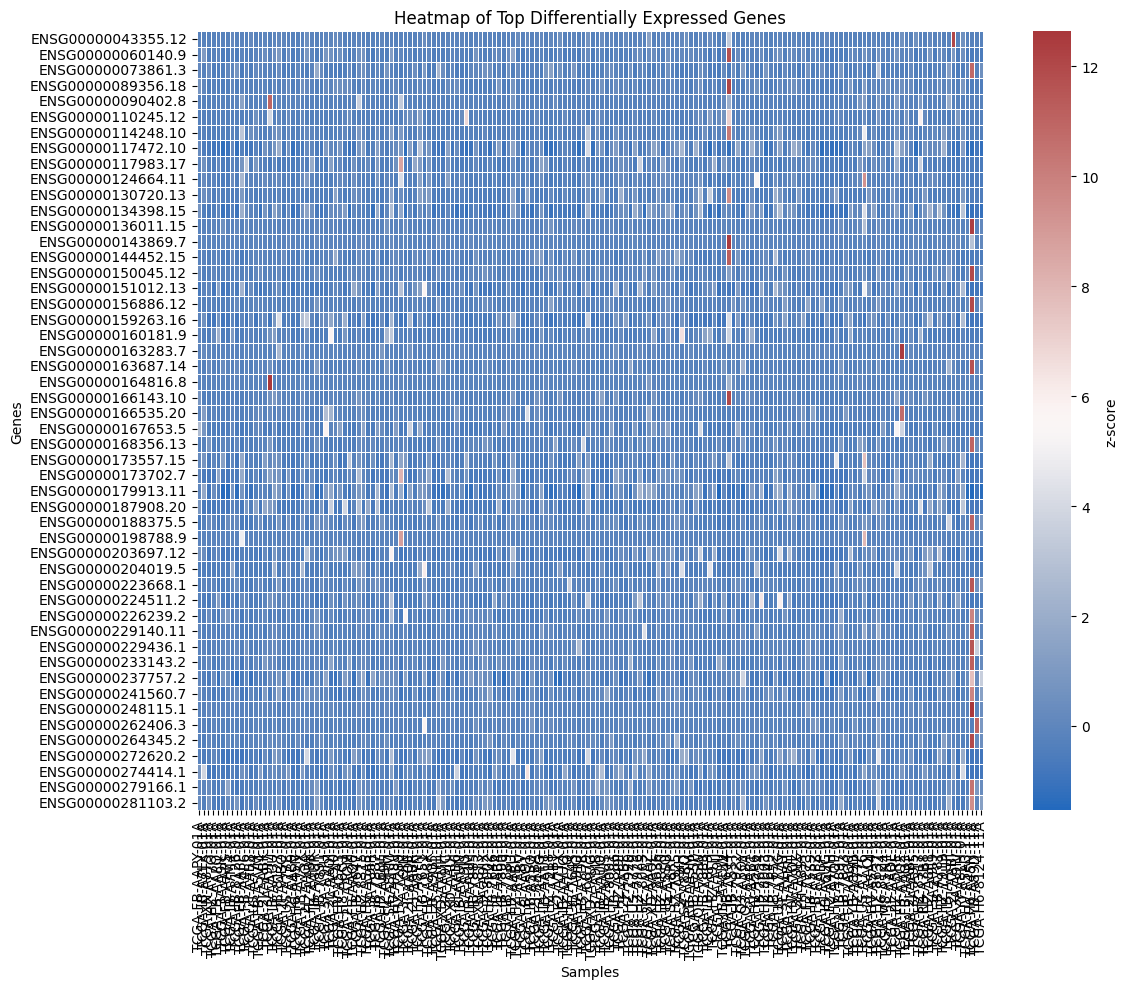

In [38]:
##expression matrix for top genes

top_expr = expr_df.loc[expr_df.index.intersection(top_genes)]
import seaborn as sns
import matplotlib.pyplot as plt

#optional : z-score normalization per gene (row)
top_expr_z = top_expr.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(top_expr_z, cmap='vlag', yticklabels=True, xticklabels=True,
            cbar_kws={'label': 'z-score'}, linewidths=0.5)

plt.title('Heatmap of Top Differentially Expressed Genes')
plt.xlabel('Samples')
plt.ylabel('Genes')
plt.tight_layout()
plt.show()

In [39]:
!pip install scipy

In [40]:
import scipy
print("SciPy version:", scipy.__version__)


SciPy version: 1.16.2


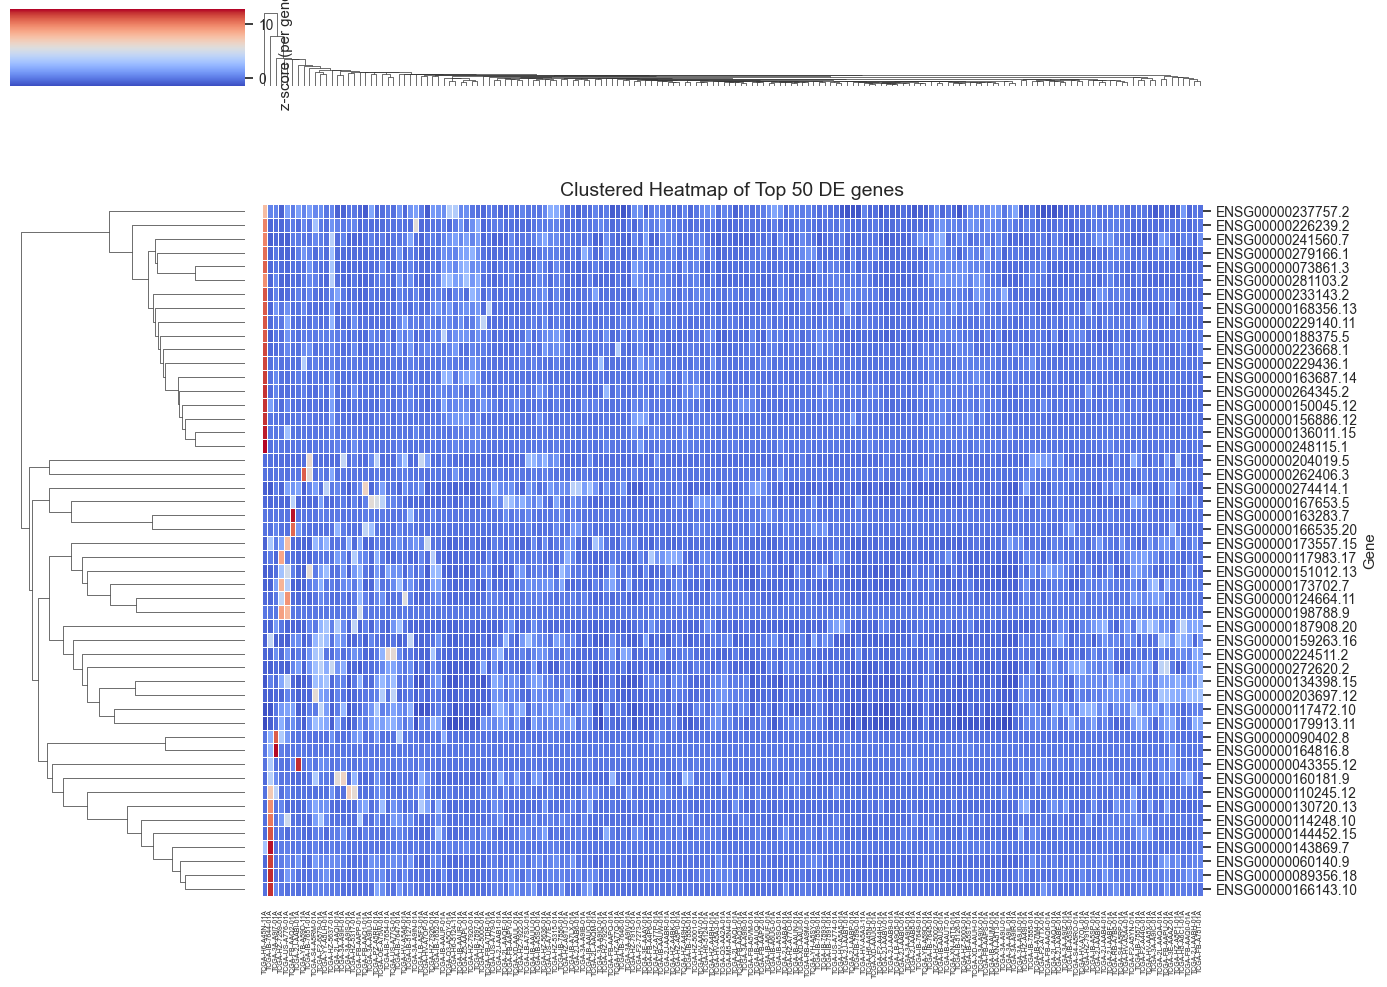

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# step 1: select top 50 DE genes based on p-value
top_n = 50
top_genes = res_df.sort_values('pvalue').head(top_n)['Gene'].astype(str).tolist()

# step 2: subset the expression matrix for top genes
expr_df.index = expr_df.index.astype(str)
top_expr = expr_df.loc[expr_df.index.intersection(top_genes)]

# step 3: z-score normalization across samples for each gene
top_expr_z = top_expr.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

#step 4: create clustermap
sns.set(font_scale=0.9)

g = sns.clustermap(
    top_expr_z,
    cmap='coolwarm',
    figsize=(14, 10),
    linewidths=0.5,
    dendrogram_ratio=(0.2, 0.1),
    col_cluster=True,
    row_cluster=True,
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'z-score (per gene)'}
)

#step 5: rotate axis
g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(),
    rotation=90,
    fontsize=5,
    ha='center'
)
# step 6: Title and layout
g.ax_heatmap.set_title('Clustered Heatmap of Top 50 DE genes', fontsize=14)
plt.tight_layout()
g.savefig("top50_de_genes_heatmap_1.png", dpi=300)  
plt.show()

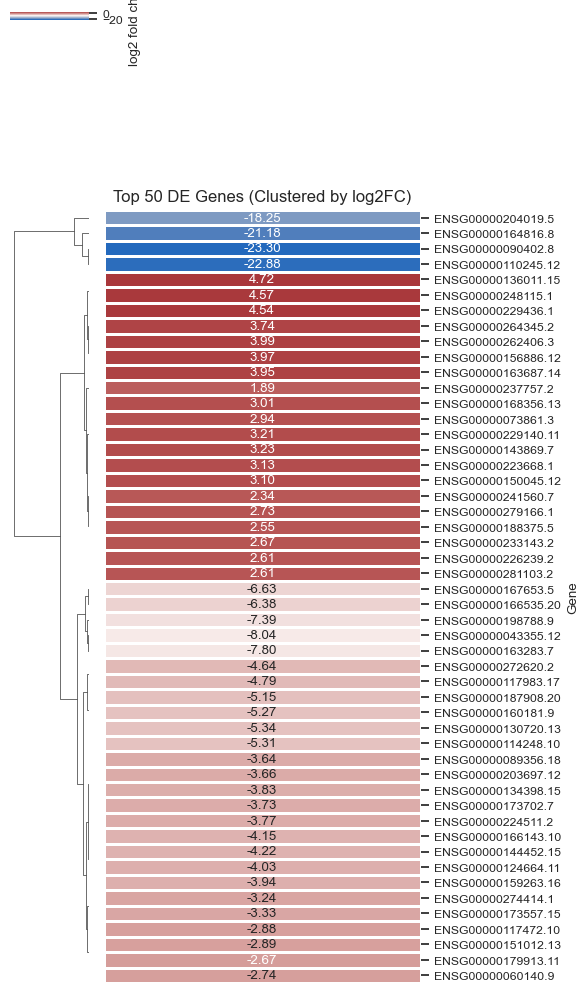

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#step 1: select top 50 genes by smallest p-value
top_n = 50
top_res = res_df.sort_values('pvalue').head(top_n)

#step 2: prepare matrix: genes are rows, one column of log2foldchange
heatmap_df = top_res[['Gene', 'log2FoldChange']].copy()
heatmap_df.set_index('Gene', inplace=True)

#optional: standardize log2FC values 
#HERE we just make sure data is 2D for clustering
data_matrix = heatmap_df.copy()

#step 3: clustered heatmap
sns.set(font_scale=0.8)
g = sns.clustermap(
    data_matrix,
    cmap='vlag',
    linewidths=0.8,
    figsize=(6, 10),
    annot=True,
    fmt=".2f",
    col_cluster=False, #only cluster rows (genes), not columns
    cbar_kws={"label": "log2 fold change"},
    dendrogram_ratio=(0.2, 0.01), #shrink col dendrogram
    xticklabels=False,
    yticklabels=True
)

g.ax_heatmap.set_title("Top 50 DE Genes (Clustered by log2FC)", fontsize=12)
plt.tight_layout()
g.savefig("top50_de_genes_heatmap_3.png", dpi=300) #save as high-res PNG
plt.show()